In [4]:
%cd ..

C:\Users\chibok


# 필요한 pakage를 import

In [1]:
import pandas as pd
import numpy as np
import tempfile
import shutil
import os
import numpy as np

from joblib import Parallel, delayed
from joblib import load, dump

import matplotlib.pyplot as plt # module for plotting
import seaborn as sns
import sklearn as sklearn
from sklearn import linear_model, cross_validation, metrics, svm, ensemble
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.cross_validation  import train_test_split, cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from scipy.stats import sem
import statsmodels.api as sm
import itertools
from sklearn.learning_curve import learning_curve


# 시각화를 하기 위한 color설정 밑 plot 정의

In [2]:
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])
dark2_cmap=ListedColormap(dark2_colors)

In [3]:
# plot confustion matrix function taken from class notes
def show_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()

    target_names = ['Not Delayed', 'Delayed']

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Convenience function to adjust plot parameters for a clear layout.
    plt.show()

In [5]:
######################################
######################################
# Matplotlib config code taken from CS109 2013 
######################################
def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 150
    rcParams['axes.color_cycle'] = dark2_colors
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

######################################
######################################
# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [6]:
df_raw_data = pd.read_csv("df_data.csv", encoding = 'cp949')

In [7]:
df_raw_data.head()

,plan,date,predict,dep,airnumber,company,status,month,day,weekday,hour,wind,wind2,temp,dist,rain,the number of delay
0,6:20,2015-02-01,6:20,6:29,OZ8901,아시아나항공,0,2,1,1,6H,0,0,-11,1000,0,0
1,6:20,2015-02-01,6:31,6:31,TW751,티웨이항공,0,2,1,1,6H,0,0,-11,1000,0,1
2,6:45,2015-02-01,6:45,6:56,OZ8903,아시아나항공,0,2,1,1,6H,0,0,-11,1000,0,0
3,6:35,2015-02-01,6:48,6:48,ZE201,이스타항공,0,2,1,1,6H,0,0,-11,1000,0,0
4,6:50,2015-02-01,6:50,7:03,OZ8907,아시아나항공,0,2,1,1,6H,0,0,-11,1000,0,1


# feature 설명



1. plan : 계획되어진 비행시간
2. date : 비행 날짜
3. predict : 예상되어지는 비행출발시간 - 비행하기 전 기장이 직접 입력한다.
4. dep : 실제 출발 시간
5. company : 항공사
6. status : 비행지연 여부 (0: 출발, 1:지연)
7. month : 비행 월( 날짜 대신 실제 분석에 쓰일 feature)
8. day : 비행 일( 날짜 대신 실제 분석에 쓰일 feature)
9. weekday : 비행 요일( 1: 일, 2:월, 3:화 ... 7: 토)
10. hour : 비행이 계획된 시간( plan 대신 실제 분석에 쓰일 feature)
11. wind : 풍향(기준은 서쪽으로 중심으로부터 틀어진 각도로 측정 예 : 서쪽에서 북쪽으로 30도 틀어져 있을 경우 30이라고 측정)
12. wind2: 풍속
13. temp : 기온
14. dist : 시정
15. rain : 강수량
16. the number of delay : 이전달의 지연 횟수

날씨데이터와 이전달의 지연횟수를 제외한 나머지 feature들은 숫자 자체의 의미보다는 categorical 의미가 강하기 때문에
one hot encoding을 통해서 더미변수로 만들어준다.

분석을 위한 데이터 전처리 전에 데이터에 대한 탐색을 먼저 한다.

# 데이터 탐색

먼저 월별로 지연 수를 살펴본다

1월,2월은 2년치가 들어가 있기 때문에, 2를 나눠서 평균치를 봐야합니다.

4월이 가장 지연이 많은 월이고 여행을 많이 가는 방학 7월, 8월, 1월, 2월은 비교적 적은 지연 수를 볼 수 있습니다.

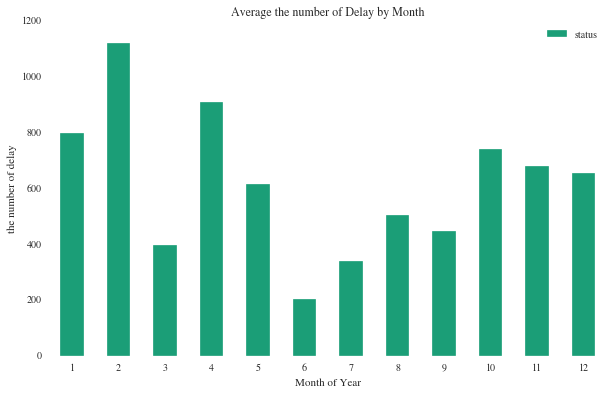

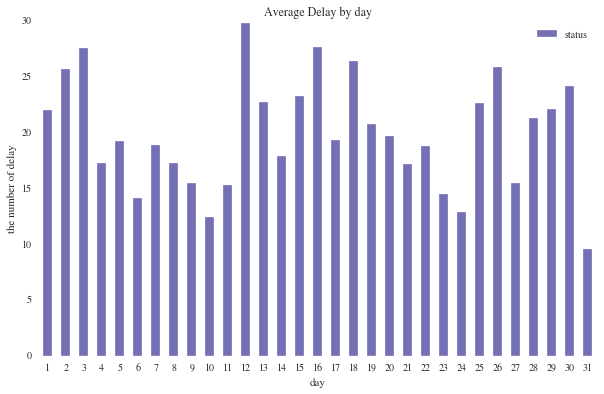

In [8]:
plt.figure(figsize=(12, 6))
df_raw_data[['month','status']].groupby('month').sum().plot(kind='bar', color=dark2_colors[0])
plt.xticks(rotation=0)
plt.xlabel('Month of Year')
plt.ylabel('the number of delay')
plt.title('Average the number of Delay by Month')
remove_border()

df_raw_data_day=df_raw_data[[u'day',u'status']].groupby(u'day').sum()
df_raw_data_day=df_raw_data_day/12
df_raw_data_day.plot(kind='bar', color=dark2_colors[2])
plt.xticks(rotation=0)
plt.xlabel('day')
plt.ylabel('the number of delay')
plt.title('Average Delay by day')
remove_border()

요일별 지연 수를 봤을 때, 화요일이 가장 많은 지연 수가 나타나지만
각 요일별로 눈에 띄는 큰 차이는 없었다.

시간별 지연 수는 18시, 19시, 15시 순으로 지연 수가 많았고, 아침시간이나 늦은 밤시간에는 지연이 되는 경우 거의 존재 하지 않았다.


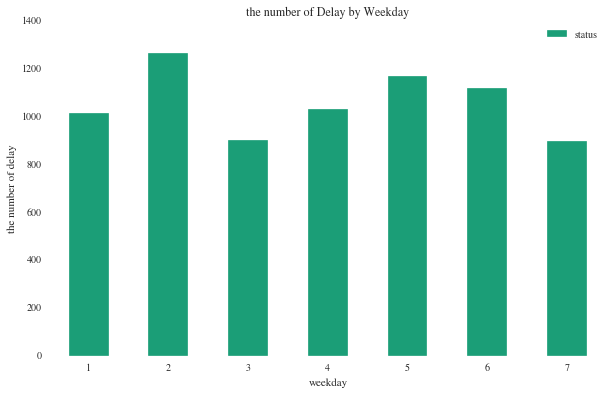

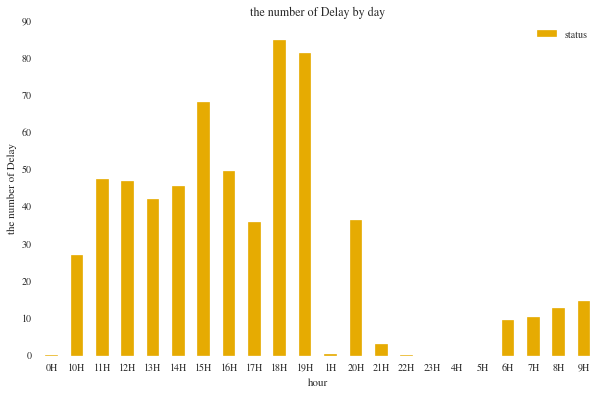

In [9]:
plt.figure(figsize=(12, 6))
df_raw_data[['weekday','status']].groupby('weekday').sum().plot(kind='bar', color=dark2_colors[7])
plt.xticks(rotation=0)
plt.xlabel('weekday')
plt.ylabel('the number of delay')
plt.title('the number of Delay by Weekday')
remove_border()

df_raw_data_day=df_raw_data[['hour',u'status']].groupby(u'hour').sum()
df_raw_data_day=df_raw_data_day/12
df_raw_data_day.plot(kind='bar', color=dark2_colors[5])
plt.xticks(rotation=0)
plt.xlabel('hour')
plt.ylabel('the number of Delay')
plt.title('the number of Delay by day')
remove_border()

In [10]:
df_raw_data=df_raw_data.drop(["plan", "date","predict", "dep", "airnumber"], axis = 1)

In [11]:
df_raw_data.columns

Index([u'company', u'status', u'month', u'day', u'weekday', u'hour', u'wind', u'wind2', u'temp', u'dist', u'rain', u'the number of delay'], dtype='object')

In [12]:
df_raw_datas = pd.DataFrame(df_raw_data, columns = ["wind", "wind2","dist","temp", "rain", "the number of delay", "company", "month", "day", "hour", "weekday","status"])

In [13]:
df_raw_datas.loc[:,u"company"] = LabelEncoder().fit_transform(df_raw_datas[u"company"])
dfX2 = pd.DataFrame(OneHotEncoder().fit_transform(df_raw_datas[u"company"].as_matrix()[:,np.newaxis]).toarray(), 
                    columns=["koreanair","asianair","busanair","estarair","jejuair","jinair","taway"], index=df_raw_datas.index)
df_raw_datas = pd.concat([df_raw_datas, dfX2], axis=1)
del(df_raw_datas[u"company"])

항공사별 지연 수를 살펴봤습니다.

각 항공사별 운항횟수가 다르기 때문에, 각 항공사의 지연 수를 구하고, 전체 지연의 수로 나눠서 비율로 살펴보았습니다.

대한항공은 가장 많은 운항을 하지만, 적은 지연 수를 보였고, 아시아나도 대한항공 다음으로 많은 운항을 하지만 타 저가항공보다 비교적 적은 지연 수를 보였습니다. 

부산에어나 진에어는 많은 운항 수가 아님에도 불구하고 지연이 되는 항공기가 많았습니다.

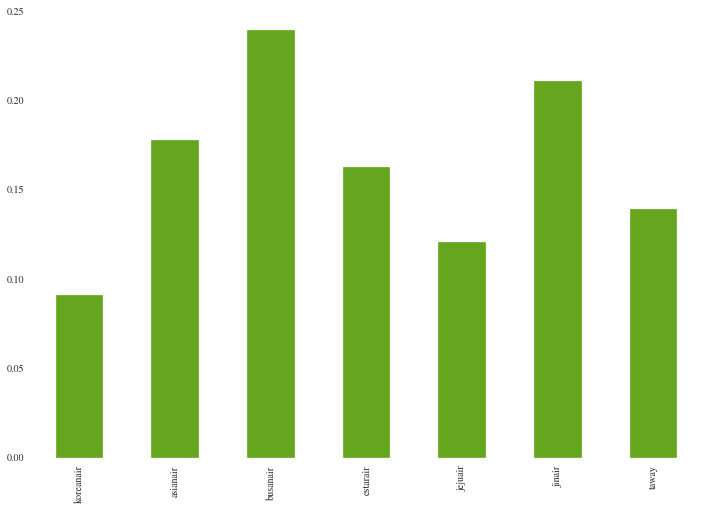

In [14]:
delay_raw_datas = df_raw_datas[df_raw_data["status"] == 1]
number_company = df_raw_datas[[u'koreanair',            u'asianair',            u'busanair',            u'estarair',             u'jejuair',              u'jinair',               u'taway']].sum()
number_delay=delay_raw_datas[[u'koreanair',            u'asianair',            u'busanair',            u'estarair',             u'jejuair',              u'jinair',               u'taway']].sum()
rate_delay_company=number_delay/number_company
rate_delay_company.plot(kind='bar', figsize =(12,8), color=dark2_colors[4])

# 데이터 탐색으로 얻은 결론

항공사, 월, 일, 요일, 시간별로 살펴본 결과 

요일별은 지연의 수에 큰 차이를 보이지 않았지만, 

항공사와 시간은 특히 지연이 많이 되는 카테고리를 가지고 있었습니다.

각 변수를 one-hot-encoding을 통해 더미feature로 만든 후

각 feature에 대한 class_weight를 주는 것이 필요하다고 결론

# 데이터 전처리 하기

In [15]:
df_raw_datas.loc[:,u"month"] = LabelEncoder().fit_transform(df_raw_datas[u"month"])
dfX6 = pd.DataFrame(OneHotEncoder().fit_transform(df_raw_datas[u"month"].as_matrix()[:,np.newaxis]).toarray(), 
                    columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], index=df_raw_datas.index)
df_raw_datas = pd.concat([df_raw_datas, dfX6], axis=1)
del(df_raw_datas[u"month"])

In [16]:
df_raw_datas.loc[:,u"hour"] = LabelEncoder().fit_transform(df_raw_datas[u"hour"])
dfX3 = pd.DataFrame(OneHotEncoder().fit_transform(df_raw_datas[u"hour"].as_matrix()[:,np.newaxis]).toarray(), 
                    columns=[u"0H",u"10H", u"11H",  u"12H", u"13H", u"14H", u"15H", u"16H", u"17H", u"18H", u"19H", u"1H", u"20H", u"21H", u"22H", u"23H", u"4H", u"5H", u"6H", u"7H", u"8H", u"9H" ], index=df_raw_datas.index)
df_raw_datas = pd.concat([df_raw_datas, dfX3], axis=1)
del(df_raw_datas[u"hour"])


In [17]:
from sklearn.preprocessing import LabelEncoder
df_raw_datas.loc[:,u"day"] = LabelEncoder().fit_transform(df_raw_datas[u"day"])
df_raw_datas.tail()

,wind,wind2,dist,temp,rain,the number of delay,day,weekday,status,koreanair,asianair,busanair,estarair,jejuair,jinair,taway,1,2,3,4,5,6,7,8,9,10,11,12,0H,10H,11H,12H,13H,14H,15H,16H,17H,18H,19H,1H,20H,21H,22H,23H,4H,5H,6H,7H,8H,9H
48112,32,14,1000,-0.8,0,5,8,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
48113,32,14,1000,-0.8,0,13,8,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
48114,32,14,1000,-0.8,0,14,8,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
48115,32,14,1000,-0.8,0,13,8,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
48116,32,14,1000,-0.8,0,7,8,4,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [18]:
from sklearn.preprocessing import OneHotEncoder
dfX2 = pd.DataFrame(OneHotEncoder().fit_transform(df_raw_datas["day"].as_matrix()[:,np.newaxis]).toarray(), 
                    columns=[u"day1",u"day2",u"day3",u"day4",u"day5",u"day6",u"day7",u"day8",u"day9",u"day10",u"day11",u"day12",u"day13",u"day14",u"day15",u"day16",u"day17",u"day18",u"day19",u"day20",u"day21",u"day22",u"day23",u"day24",u"day25",u"day26",u"day27",u"day28",u"day29",u"day30",u"day31"], index=df_raw_datas.index)
df_raw_datas = pd.concat([df_raw_datas, dfX2], axis=1)
#del(df_raw_datas[u"day"])
df_raw_datas.tail()

,wind,wind2,dist,temp,rain,the number of delay,day,weekday,status,koreanair,asianair,busanair,estarair,jejuair,jinair,taway,1,2,3,4,5,6,7,8,9,10,11,12,0H,10H,11H,12H,13H,14H,15H,16H,17H,18H,19H,1H,20H,21H,22H,23H,4H,5H,6H,7H,8H,9H,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30,day31
48112,32,14,1000,-0.8,0,5,8,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48113,32,14,1000,-0.8,0,13,8,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48114,32,14,1000,-0.8,0,14,8,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48115,32,14,1000,-0.8,0,13,8,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48116,32,14,1000,-0.8,0,7,8,4,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
del(df_raw_datas[u"day"])

In [20]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
dfX2 = pd.DataFrame(OneHotEncoder().fit_transform(df_raw_datas[u"weekday"].as_matrix()[:,np.newaxis]).toarray(), 
                    columns=["sun","mon","tue","wen","thus","fri", "sat"], index=df_raw_datas.index)
df_raw_datas = pd.concat([df_raw_datas, dfX2], axis=1)
#del(df_raw_data[u"weekday"])
df_raw_datas.tail()

,wind,wind2,dist,temp,rain,the number of delay,weekday,status,koreanair,asianair,busanair,estarair,jejuair,jinair,taway,1,2,3,4,5,6,7,8,9,10,11,12,0H,10H,11H,12H,13H,14H,15H,16H,17H,18H,19H,1H,20H,21H,22H,23H,4H,5H,6H,7H,8H,9H,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30,day31,sun,mon,tue,wen,thus,fri,sat
48112,32,14,1000,-0.8,0,5,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48113,32,14,1000,-0.8,0,13,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48114,32,14,1000,-0.8,0,14,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48115,32,14,1000,-0.8,0,13,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48116,32,14,1000,-0.8,0,7,4,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [21]:
del(df_raw_datas[u"weekday"])

In [22]:
df_raw_datas.tail()

,wind,wind2,dist,temp,rain,the number of delay,status,koreanair,asianair,busanair,estarair,jejuair,jinair,taway,1,2,3,4,5,6,7,8,9,10,11,12,0H,10H,11H,12H,13H,14H,15H,16H,17H,18H,19H,1H,20H,21H,22H,23H,4H,5H,6H,7H,8H,9H,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30,day31,sun,mon,tue,wen,thus,fri,sat
48112,32,14,1000,-0.8,0,5,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48113,32,14,1000,-0.8,0,13,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48114,32,14,1000,-0.8,0,14,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48115,32,14,1000,-0.8,0,13,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48116,32,14,1000,-0.8,0,7,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [23]:
df_raw_datas.columns

Index([               u'wind',               u'wind2',                u'dist',                u'temp',                u'rain', u'the number of delay',              u'status',           u'koreanair',            u'asianair',            u'busanair',            u'estarair',             u'jejuair',              u'jinair',               u'taway',                      1,                      2,                      3,                      4,                      5,                      6,
                            7,                      8,                      9,                     10,                     11,                     12,                  u'0H',                 u'10H',                 u'11H',                 u'12H',                 u'13H',                 u'14H',                 u'15H',                 u'16H',                 u'17H',                 u'18H',                 u'19H',                  u'1H',                 u'20H',                 u'21H',
                       u'2

 df_dfX는 feature로 쓸 모든 변수들을 모은 것
 
 df_dfy는 target값 [0:정상출발, 1:지연]로만 이루어짐

In [24]:
df_dfX = df_raw_datas.drop(["status"], axis=1)
df_dfy = df_raw_datas["status"]

In [25]:
df_hour=df_dfX[u"18H"]
list(df_hour)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

real value를 가진 변수 6개를 모아서 스케일링을 시켜준다
 - 각 변수들의 분포모양을 정규분포에 가깝게 하고 condition probablity를 줄이기 위해서
 
스케일링을 한 후 분포모양을 살펴보았지만, 딱히 정규분포로 가까워지는 feature는 없었다.
 - 왼쪽으로 몰린 모양을 가진 feature는 log를 취하면 보통정규분포로 가지만,
   
   실제 log값을 취했을 때, 무한대값과 마이너스 무한대값이 나와서 스케일링 시키지 않고 분석에 돌입

In [26]:
scaler = StandardScaler()
df_coun_data = df_dfX[["wind","wind2","temp","dist","rain",u'the number of delay']]
scale_coun_data = scaler.fit_transform(df_coun_data)

C:\Users\chibok\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


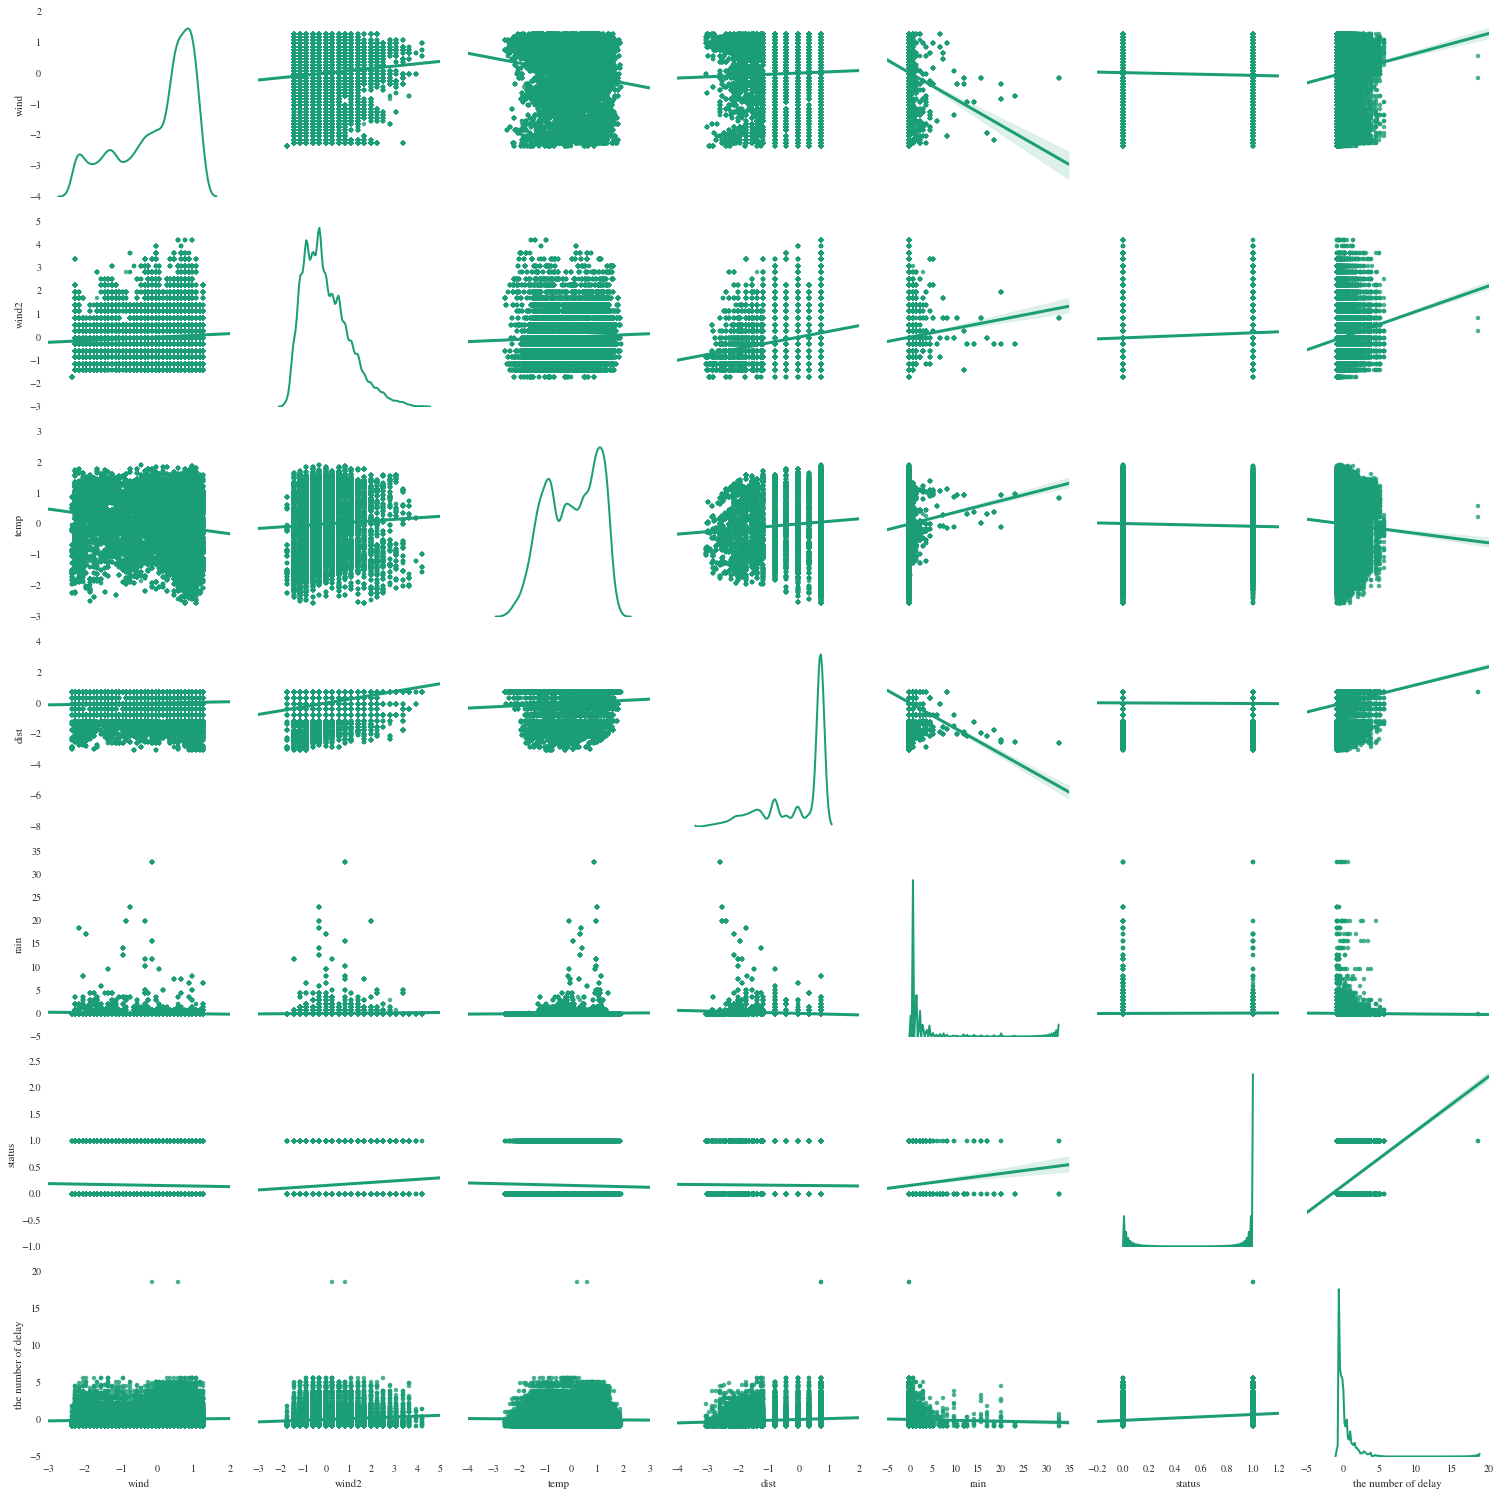

In [27]:
df_scale_coun_data = pd.DataFrame(scale_coun_data, columns = ["wind","wind2","temp","dist","rain",u'the number of delay'])
df_scale_coun_data = pd.concat([df_scale_coun_data, df_dfy], axis=1)
sns.pairplot(df_scale_coun_data, diag_kind="kde", kind="reg" ,vars = ["wind","wind2","temp","dist","rain","status",u'the number of delay'], size=3)
plt.show()

# -분석 

- logistic regression 
- randomforest
- SVM
- Navie bayes(gaussian + multinomial)

In [27]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_dfX,df_dfy, test_size=0.30, random_state=20)

In [28]:
from sklearn.linear_model import LogisticRegression
X = X_train.values
y = y_train.values
y = y.ravel()
testX = X_test.values
testy = y_test.values

In [29]:
clf_logic = LogisticRegression(C=100, penalty='l2', class_weight = 'auto')

In [31]:
model = clf_logic.fit(X,y)

C:\Users\chibok\Anaconda2\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


In [32]:
logic_scores = cross_val_score(model, X, y, scoring='recall', n_jobs=-1) 
print (logic_scores.min(), logic_scores.mean(), logic_scores.max())

0.698843930636 0.704046242775 0.711560693642


In [33]:
y_pred = model.predict(testX)
classif_rate = np.mean(y_pred.ravel() == testy.ravel()) * 100
print("classif_rate: %f " % classif_rate)

classif_rate: 70.670546 


In [34]:
from sklearn import metrics
print(metrics.classification_report(testy, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.71      0.80     12223
          1       0.30      0.69      0.42      2213

avg / total       0.83      0.71      0.74     14436



# logistic regression 분석 결과

-class_weight를 줘서 분석한 결과 recall은 70%를 나타났다. 
    recall은 실제 지연인 것을 지연으로 예측한 비율을 보여주는 수치입니다.

-fall-out은 실제 지연이지만, 출발로 예측한 비율입니다.
    fall-out 대비 recall이 높다면 좋은 예측 모델이라고 볼 수 있습니다.

하지만, 실제 정상으로 출발했지만, 지연 될 것으로 예측한 것은 158%로 실제 지연된 수를 월등히 넘어섭니다.

최대한 recall이 높으면서 위의 비율을 줄이는 것이 좋은 모델이라고 할 수 있습니다.

Confusion matrix
      0     1
0  8666  3557
1   677  1536

precision = 0.30, recall = 0.69, F1 = 0.42, accuracy = 0.71

          0        1
0  0.708991  1.60732
1  0.055387  0.69408


C:\Users\chibok\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


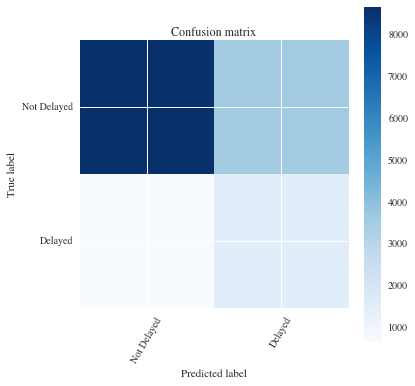

In [35]:
cm_lr = confusion_matrix(testy, y_pred)
print("Confusion matrix")
print(pd.DataFrame(cm_lr))
report_lr = precision_recall_fscore_support(list(testy), list(y_pred), average='micro')
print ("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % 
        (report_lr[0], report_lr[1], report_lr[2], accuracy_score(list(testy), list(y_pred))))
print(pd.DataFrame(cm_lr.astype(np.float64) / cm_lr.sum(axis=1)))
    
show_confusion_matrix(cm_lr)


# RandomForest
- Ntree에 따라서 recall의 수치를 확인 
 =>NTree를 결정하기 위해서

In [30]:
# set the number of input variables, m - use a rule of thumb for classification. 
# sqrt of the number of original features (Hastie et al. Ch. 15.3)



Ntrees = 50
Trees = np.arange(Ntrees)+1
m = np.sqrt(X.shape[1]).astype(int)
cv = 10
clf_scores = np.zeros((Ntrees,cv))
    
for tree in Trees:
    cols = (tree - 1)
    clf = ensemble.RandomForestClassifier(n_estimators=tree, max_features=m, random_state=0, n_jobs = -1)
    clf_scores[cols,:] = cross_validation.cross_val_score(clf, X, y, cv=cv, scoring = 'recall')

n_estimator가 1일때 가장 recall이 높게 나온것을 확인할 수 있습니다.

<function matplotlib.pyplot.show>

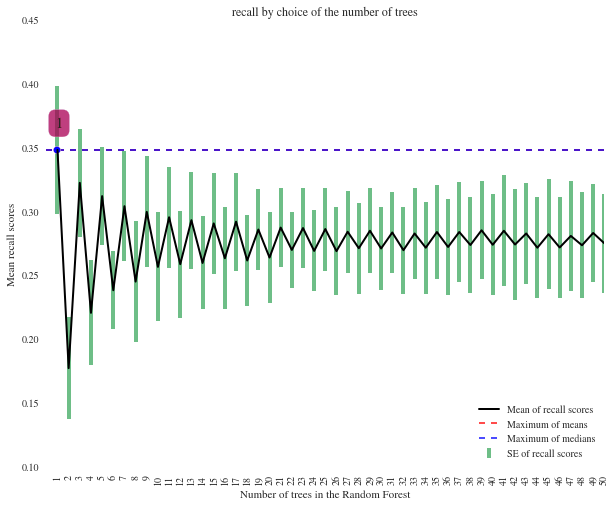

In [36]:
score_means = np.mean(clf_scores, axis=1)
score_std = np.std(clf_scores, axis=1)
score_medians = np.median(clf_scores, axis=1)
plt.subplots(figsize=(10,8))
plt.hlines(np.max(score_means),0, 51, linestyle='--', color='red', linewidth=2, alpha=0.7,  zorder = 2, label= 'Maximum of means')
plt.hlines(np.max(score_medians),0, 51, linestyle='--',color='blue', linewidth=2, alpha=0.7,  zorder = 2, label= 'Maximum of medians')
plt.scatter((np.argmax(score_means)+1),np.max(score_means), s=50, c='red', marker='o', zorder=3)
plt.scatter((np.argmax(score_medians)+1),np.max(score_medians), s=50, c='blue', marker='o', zorder=3)
plt.plot(Trees,score_means, zorder=3, c= 'k', label= 'Mean of recall scores')
plt.errorbar(Trees, score_means, yerr = 2*score_std,color='#31a354', alpha =0.7, capsize=20, elinewidth=4, linestyle="None", zorder = 1, label= 'SE of recall scores')
plt.annotate((np.argmax(score_medians)+1), 
    xy = ((np.argmax(score_medians)+1), np.max(score_medians)), 
    xytext = (5, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'blue', alpha = 0.5))
plt.annotate((np.argmax(score_means)+1), 
    xy = ((np.argmax(score_means)+1), np.max(score_means)), 
    xytext = (5, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5))
plt.title('recall by choice of the number of trees')
plt.legend(frameon=False, loc='lower right')
plt.ylabel('Mean recall scores')
plt.xlabel('Number of trees in the Random Forest')
plt.xlim(0, 41)
plt.xticks(Trees,rotation=90)
remove_border()
plt.show

In [31]:
#overfitting!
clf_rf = RandomForestClassifier(n_estimators=1, n_jobs=-1 ,class_weight='auto')
clf_rf.fit(X, y)

# Evaluate on test set
pred = clf_rf.predict(X)

# RandomForest 분석 결과

X, y로 training 시킨 결과 
좋은 결과를 얻을 수 있었습니다.

Fall-out 0.04 비해 recall 0.76이 나왔고, 
실제로 출발했지만, 지연으로 예측된 비율로 0.25로 비교적 낮았습니다.

Confusion matrix
       0     1
0  27152  1339
1   1194  3996

precision = 0.75, recall = 0.77, F1 = 0.76, accuracy = 0.92

          0         1
0  0.953003  0.257996
1  0.041908  0.769942


C:\Users\chibok\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


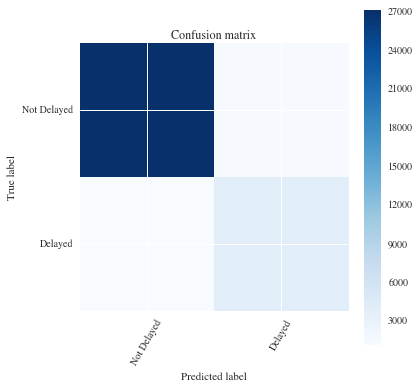

In [38]:
cm_rf = confusion_matrix(y, pred)
print("Confusion matrix")
print(pd.DataFrame(cm_rf))
report_rf = precision_recall_fscore_support(list(y), list(pred), average='micro')
print ("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % 
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(y), list(pred))))
print(pd.DataFrame(cm_rf.astype(np.float64) / cm_rf.sum(axis=1)))
    
show_confusion_matrix(cm_rf)

In [39]:
from sklearn import metrics
print(metrics.classification_report(y, pred))

             precision    recall  f1-score   support

          0       0.96      0.95      0.96     28491
          1       0.75      0.77      0.76      5190

avg / total       0.93      0.92      0.93     33681



In [40]:
test_pred = clf_rf.predict(testX)

하지만 testX로 예측한 결과는 좋지 못했습니다.

X,y로 overfitting 된 것으로 보입니다.

logistic regression에 비해서
fall-out 비율은 0.11로 높아졌고 recall은 0.34 낮아졌지만

0.65로 실제출발했지만, 지연으로 예측된 비율도 낮아진 것을 볼 수 있습니다.

Confusion matrix
       0     1
0  10750  1473
1   1385   828

precision = 0.36, recall = 0.37, F1 = 0.37, accuracy = 0.80

          0         1
0  0.879489  0.665612
1  0.113311  0.374153


C:\Users\chibok\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


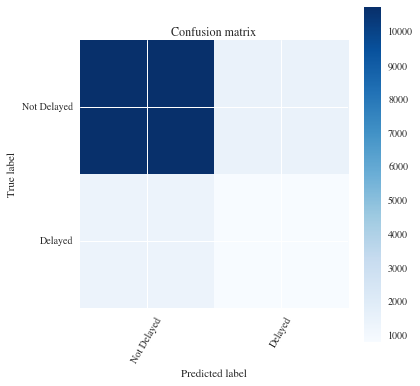

In [41]:
cm_rf = confusion_matrix(testy, test_pred)
print("Confusion matrix")
print(pd.DataFrame(cm_rf))
report_rf = precision_recall_fscore_support(list(testy), list(test_pred), average='micro')
print ("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % 
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(testy), list(test_pred))))
print(pd.DataFrame(cm_rf.astype(np.float64) / cm_rf.sum(axis=1)))
    
show_confusion_matrix(cm_rf)

# SVC 분석

In [42]:
from sklearn.svm import SVC

clf_svc = SVC(kernel='rbf', C=100, gamma=0.001, class_weight ='auto')
svc =  SVC(kernel='rbf', C=100, gamma=0.001, class_weight ='auto').fit(X, y)
SVC_scores = cross_val_score(svc, X, y, scoring='recall', n_jobs = -1) 
print (SVC_scores.min(), SVC_scores.mean(), SVC_scores.max())

0.671098265896 0.677842003854 0.682658959538


In [93]:
clf_svc = SVC(kernel='rbf', C=100, gamma=0.001, class_weight ='auto')

In [43]:
test_pred_svc = svc.predict(testX)

In [44]:
from sklearn import metrics
print(metrics.classification_report(testy, test_pred_svc))

             precision    recall  f1-score   support

          0       0.93      0.76      0.84     12223
          1       0.35      0.70      0.46      2213

avg / total       0.84      0.75      0.78     14436



# SVC(kernel = rbf) 분석결과

-대체로 logistic regression과 비슷한 결과
  
  지연의 recall에서는 0.7로 비슷한 결과를 나타냈지만 출발의 recall은 0.75로 높은 결과를 보였습니다.
  
  이 결과 전체의 recall값을 좀 더 높은 결과를 보였습니다.

Confusion matrix
      0     1
0  9277  2946
1   654  1559

precision = 0.35, recall = 0.70, F1 = 0.46, accuracy = 0.75

          0         1
0  0.758979  1.331225
1  0.053506  0.704474


C:\Users\chibok\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


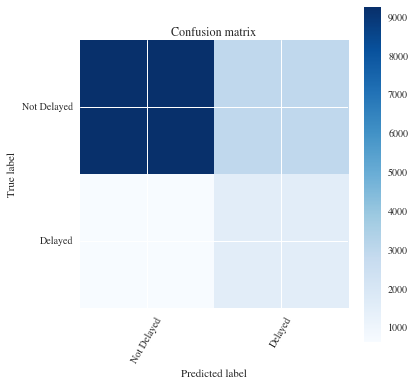

In [45]:
cm_svc = confusion_matrix(testy, test_pred_svc)
print("Confusion matrix")
print(pd.DataFrame(cm_svc))
report_svc = precision_recall_fscore_support(list(testy), list(test_pred_svc), average='micro')
print ("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % 
        (report_svc[0], report_svc[1], report_svc[2], accuracy_score(list(testy), list(test_pred_svc))))
print(pd.DataFrame(cm_svc.astype(np.float64) / cm_svc.sum(axis=1)))
    
show_confusion_matrix(cm_svc)

# 중요 Feature 확인하기

 -feature들 중 어떤 것이 영향이 큰지 확인합니다.
   
   영향 정도에 따라 weight를 준다면 더 좋은 결과 얻을 수 있다고 생각했습니다.
   

C:\Users\chibok\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


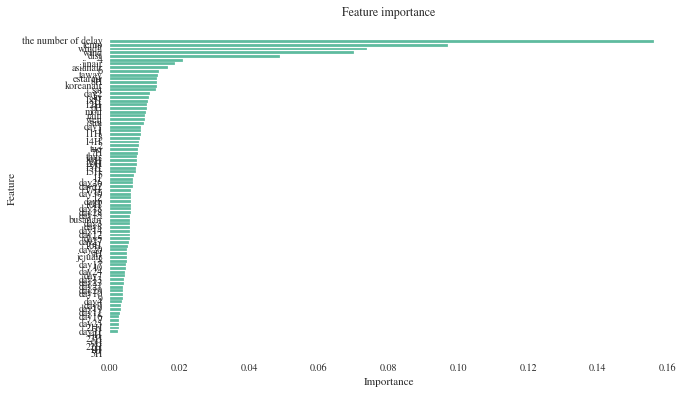

In [47]:
feature_names =[ u'wind',               u'wind2',                u'dist',                u'temp',                u'rain', u'the number of delay',           u'koreanair',            u'asianair',            u'busanair',            u'estarair',             u'jejuair',              u'jinair',               u'taway',                      1,                      2,                      3,                      4,                      5,                      6,
                            7,                      8,                      9,                     10,                     11,                     12,                  u'0H',                 u'10H',                 u'11H',                 u'12H',                 u'13H',                 u'14H',                 u'15H',                 u'16H',                 u'17H',                 u'18H',                 u'19H',                  u'1H',                 u'20H',                 u'21H',
                       u'22H',                 u'23H',                  u'4H',                  u'5H',                  u'6H',                  u'7H',                  u'8H',                  u'9H',                u'day1',                u'day2',                u'day3',                u'day4',                u'day5',                u'day6',                u'day7',                u'day8',                u'day9',               u'day10',               u'day11',               u'day12',
                     u'day13',               u'day14',               u'day15',               u'day16',               u'day17',               u'day18',               u'day19',               u'day20',               u'day21',               u'day22',               u'day23',               u'day24',               u'day25',               u'day26',               u'day27',               u'day28',               u'day29',               u'day30',               u'day31',                 u'sun',
                       u'mon',                 u'tue',                 u'wen',                u'thus',                 u'fri',                 u'sat']
importances = pd.Series(clf_rf.feature_importances_, index=feature_names)
importances.sort()

plt.barh(np.arange(len(importances)), importances, alpha=0.7)
plt.yticks(np.arange(.5,len(importances),1), importances.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance')
remove_border()
plt.show()

In [48]:
importances = pd.Series(clf_rf.feature_importances_, index=feature_names)
clf_rf.feature_importances_[6:]

array([  1.34681122e-02,   1.66612633e-02,   5.97454857e-03,
         1.37028608e-02,   5.01515811e-03,   1.87995023e-02,
         1.39757780e-02,   9.05062747e-03,   8.29712038e-03,
         8.84032175e-03,   2.10962962e-02,   6.94208768e-03,
         1.40774766e-02,   2.71961705e-03,   4.93416742e-03,
         3.88574118e-03,   4.82681736e-03,   6.86016252e-03,
         6.23823848e-03,   0.00000000e+00,   6.13981372e-03,
         8.90833209e-03,   1.08469310e-02,   7.53196965e-03,
         8.49350530e-03,   7.65586440e-03,   5.36693936e-03,
         6.25245869e-03,   1.10202426e-02,   7.86879246e-03,
         0.00000000e+00,   7.74191573e-03,   2.59849086e-03,
         0.00000000e+00,   0.00000000e+00,   5.98432878e-05,
         0.00000000e+00,   1.06840066e-02,   8.05278092e-03,
         1.36002273e-02,   5.04643356e-03,   9.08978837e-03,
         1.15895264e-02,   5.97321576e-03,   3.59350666e-03,
         5.72876219e-03,   6.19424123e-03,   4.33797233e-03,
         5.86493245e-03,

In [49]:
for kk in reversed(range(16)):
    selector = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=kk+2).fit(X, y)
    best_features = np.where(selector.get_support())[0]
    print(best_features)

[ 1  5  6  8 11 13 15 16 18 19 31 34 35 43 44 45 46]
[ 1  5  6  8 11 13 15 16 18 19 31 34 35 43 44 45]
[ 1  5  6 11 13 15 16 18 19 31 34 35 43 44 45]
[ 1  5  6 11 13 15 16 18 31 34 35 43 44 45]
[ 1  5  6 11 13 15 16 18 34 35 43 44 45]
[ 1  5  6 11 13 16 18 34 35 43 44 45]
[ 1  5  6 11 16 18 34 35 43 44 45]
[ 1  5  6 16 18 34 35 43 44 45]
[ 1  5  6 16 18 35 43 44 45]
[ 1  5  6 18 35 43 44 45]
[ 1  5  6 18 43 44 45]
[ 1  5  6 43 44 45]
[ 5  6 43 44 45]
[ 5  6 43 44]
[ 5  6 43]
[ 5 43]


In [50]:
df_dfX.columns[[ 1,5,6,8,11,19, 22, 23, 31, 32, 33, 34, 35, 37, 38, 40, 41]]

Index([u'wind2', u'the number of delay', u'koreanair', u'busanair', u'jinair', 7, 10, 11, u'15H', u'16H', u'17H', u'18H', u'19H', u'20H', u'21H', u'23H', u'4H'], dtype='object')

In [51]:
df_dfX.columns

Index([               u'wind',               u'wind2',                u'dist',                u'temp',                u'rain', u'the number of delay',           u'koreanair',            u'asianair',            u'busanair',            u'estarair',             u'jejuair',              u'jinair',               u'taway',                      1,                      2,                      3,                      4,                      5,                      6,                      7,
                            8,                      9,                     10,                     11,                     12,                  u'0H',                 u'10H',                 u'11H',                 u'12H',                 u'13H',                 u'14H',                 u'15H',                 u'16H',                 u'17H',                 u'18H',                 u'19H',                  u'1H',                 u'20H',                 u'21H',                 u'22H',
                       u'2

# Navie Bayes 분석

- 먼저 real values를 가진 변수와 categorical value를 가진 변수 분리 한다.
- 그리고 real value를 가진 변수는 gaussian naive bayes, categorical value를 가진 변수는 multinomial naive bayes을 training 시킨다.
- 각 각의 예측에 대한 확률 값들을 다시 gaussian naive bayes으로 training시킨다.

In [72]:
X_gau=pd.DataFrame(X_train, columns = ["wind", "wind2", "dist", "rain","temp","the number of delay"])
X_gau_test=pd.DataFrame(X_test, columns = ["wind", "wind2", "dist", "rain","temp","the number of delay"])
X_gau.tail()

,wind,wind2,dist,rain,temp,the number of delay
31962,29,2,320,0,16.4,0
23452,15,11,600,0,22.6,4
23775,14,3,450,0,28.2,7
37135,36,1,1000,0,-1.2,3
27098,30,6,1000,0,24.7,1


In [73]:
X_cat = pd.DataFrame(X_train, columns = [u'koreanair',            u'asianair',            u'busanair',            u'estarair',             u'jejuair',              u'jinair',               u'taway',                  u'0H',                 u'10H',                 u'11H',                 u'12H',                 u'13H',                 u'14H',                 u'15H',
                       u'16H',                 u'17H',                 u'18H',                 u'19H',                  u'1H',                 u'20H',                 u'21H',                 u'22H',                 u'23H',                  u'4H',                  u'5H',                  u'6H',                  u'7H',                  u'8H',                  u'9H',                   1,                   2,                   3,                   4,                   5,
                         6,                   7,                   8,                   9,                  10,                  11,                  12,                u'day1',                u'day2',                u'day3',                u'day4',                u'day5',                u'day6',                u'day7',                u'day8',                u'day9',               u'day10',               u'day11',               u'day12',               u'day13',
                     u'day14',               u'day15',               u'day16',               u'day17',               u'day18',               u'day19',               u'day20',               u'day21',               u'day22',               u'day23',               u'day24',               u'day25',               u'day26',               u'day27',               u'day28',               u'day29',               u'day30',               u'day31',                 u'sun',                 u'mon',
                       u'tue',                 u'wen',                u'thus',                 u'fri',                 u'sat'])
X_cat_test = pd.DataFrame(X_test, columns = [u'koreanair',            u'asianair',            u'busanair',            u'estarair',             u'jejuair',              u'jinair',               u'taway',                  u'0H',                 u'10H',                 u'11H',                 u'12H',                 u'13H',                 u'14H',                 u'15H',
                       u'16H',                 u'17H',                 u'18H',                 u'19H',                  u'1H',                 u'20H',                 u'21H',                 u'22H',                 u'23H',                  u'4H',                  u'5H',                  u'6H',                  u'7H',                  u'8H',                  u'9H',                   1,                   2,                   3,                   4,                   5,
                         6,                   7,                   8,                   9,                  10,                  11,                  12,                u'day1',                u'day2',                u'day3',                u'day4',                u'day5',                u'day6',                u'day7',                u'day8',                u'day9',               u'day10',               u'day11',               u'day12',               u'day13',
                     u'day14',               u'day15',               u'day16',               u'day17',               u'day18',               u'day19',               u'day20',               u'day21',               u'day22',               u'day23',               u'day24',               u'day25',               u'day26',               u'day27',               u'day28',               u'day29',               u'day30',               u'day31',                 u'sun',                 u'mon',
                       u'tue',                 u'wen',                u'thus',                 u'fri',                 u'sat'])

In [77]:
len(X_cat.columns)

79

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

In [78]:
X1 = X_gau.values
X2 = X_cat.values
y = y_train.values.ravel()
X1_test = X_gau_test.values
X2_test = X_cat_test.values
testy = y_test.values.ravel()

In [65]:
#숫자를 가진 변수들을 빼서 가우시안나이브베이지안을 적용한다.
clf1 = GaussianNB()
clf1.class_prior_ = [.1, .0, 0, .1 ,.15 ,.8]
model_ga=clf1.fit(X1, y)
proba_ga = model_ga.predict_proba(X1)

In [66]:
gau_pred = model_ga.predict(X1)

In [67]:
from sklearn import metrics
print(metrics.classification_report(y, gau_pred))

             precision    recall  f1-score   support

          0       0.87      0.95      0.91     28491
          1       0.44      0.19      0.27      5190

avg / total       0.80      0.84      0.81     33681



In [68]:
clf2 = MultinomialNB()
clf2.class_prior_ = clf_rf.feature_importances_[6:]
model_mu=clf2.fit(X2, y)
proba_mu = model_mu.predict_proba(X2)
proba_nb=np.hstack((proba_ga, proba_mu))

In [69]:
mu_pred = model_mu.predict(X2)

In [70]:
from sklearn import metrics
print(metrics.classification_report(y, mu_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92     28491
          1       0.71      0.01      0.03      5190

avg / total       0.83      0.85      0.78     33681



In [71]:
# 각 validation의 확률을 구한 다음 그 확률들을 다시 모아서 가우시안 나이브베이지안을 적용한다.
clf_final = GaussianNB()
clf_final.class_prior_ = [10, 50, 100, 0]
model_nb = clf_final.fit(proba_nb, y)
y_pred1= model_nb.predict(proba_nb)

from sklearn import metrics
print(metrics.classification_report(y, y_pred1))

             precision    recall  f1-score   support

          0       0.88      0.91      0.90     28491
          1       0.42      0.34      0.38      5190

avg / total       0.81      0.83      0.82     33681



Confusion matrix
       0     1
0  26019  2472
1   3400  1790

precision = 0.42, recall = 0.34, F1 = 0.38, accuracy = 0.83

          0         1
0  0.913236  0.476301
1  0.119336  0.344894


C:\Users\chibok\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


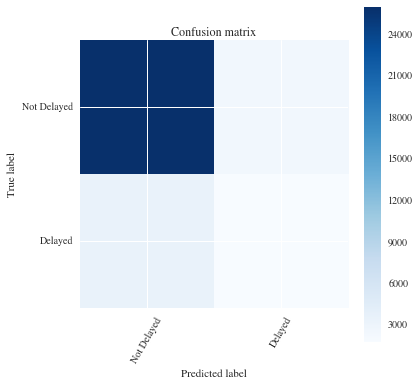

In [80]:
clf_bayes = confusion_matrix(y, y_pred1)
print("Confusion matrix")
print(pd.DataFrame(clf_bayes))
report_svc = precision_recall_fscore_support(list(y), list(y_pred1), average='micro')
print ("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % 
        (report_svc[0], report_svc[1], report_svc[2], accuracy_score(list(y), list(y_pred1))))
print(pd.DataFrame(clf_bayes.astype(np.float64) / clf_bayes.sum(axis=1)))
    
show_confusion_matrix(clf_bayes)

In [75]:
clf1 = GaussianNB()
clf1.class_prior_ = [.1, .0, 0, .1 ,.15 ,.8]
model_ga=clf1.fit(X1, y)
proba_ga = model_ga.predict_proba(X1_test)

test_gau_pred = model_ga.predict(X1_test)

from sklearn import metrics
print(metrics.classification_report(testy, test_gau_pred))

             precision    recall  f1-score   support

          0       0.87      0.96      0.91     12223
          1       0.46      0.19      0.27      2213

avg / total       0.80      0.84      0.81     14436



In [82]:
clf2 = MultinomialNB()
clf2.class_prior_ = clf_rf.feature_importances_[6:]
model_mu=clf2.fit(X2, y)
proba_mu = model_mu.predict_proba(X2_test)
proba_nb=np.hstack((proba_ga, proba_mu))

test_mu_pred = model_mu.predict(X2_test)

from sklearn import metrics
print(metrics.classification_report(testy, test_mu_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92     12223
          1       0.53      0.01      0.02      2213

avg / total       0.80      0.85      0.78     14436



# naive bayes 적용결과 

 randomforest 모델과 비슷한 결과를 볼 수 있었습니다.
 
 4가지 모델을 적용한 결과, recall만을 생각했을 경우, svm이나, logisitic 모형이 가장 좋아 보였지만
 
 실제 정상출발이지만, 지연으로 예측된 비율과 F1 score까지 생각했을 경우, randomforest와 navie bayes 이 좋은 모형으로 보여졌습니다.
 
 그래서 4가지 모델을 합쳐서, 적용할 수 있는 ensemble의 votingclssfiter를 적용해보았습니다.

In [84]:
# 각 validation의 확률을 구한 다음 그 확률들을 다시 모아서 가우시안 나이브베이지안을 적용한다.
clf_final = GaussianNB()
clf_final.class_prior_ = [10, 50, 100, 0]
model_nb = clf_final.fit(proba_nb, testy)
y_pred1= model_nb.predict(proba_nb)

from sklearn import metrics
print(metrics.classification_report(testy, y_pred1))

             precision    recall  f1-score   support

          0       0.89      0.92      0.90     12223
          1       0.43      0.34      0.38      2213

avg / total       0.82      0.83      0.82     14436



Confusion matrix
       0    1
0  11231  992
1   1457  756

precision = 0.43, recall = 0.34, F1 = 0.38, accuracy = 0.83

          0         1
0  0.918842  0.448260
1  0.119202  0.341618


C:\Users\chibok\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


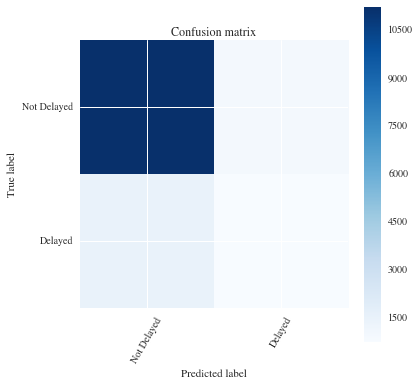

In [85]:
clf_bayes = confusion_matrix(testy, y_pred1)
print("Confusion matrix")
print(pd.DataFrame(clf_bayes))
report_svc = precision_recall_fscore_support(list(testy), list(y_pred1), average='micro')
print ("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % 
        (report_svc[0], report_svc[1], report_svc[2], accuracy_score(list(testy), list(y_pred1))))
print(pd.DataFrame(clf_bayes.astype(np.float64) / clf_bayes.sum(axis=1)))
    
show_confusion_matrix(clf_bayes)

In [91]:
def plot_learning_curve(estimator1, estimator2, estimator3, title, X, y, ylim=None, cv=None, 
                        n_jobs=1,train_sizes=np.linspace(0.1,1,5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes1, train_scores1, test_scores1 = learning_curve(estimator1, X, y, cv=cv, 
                                                               n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes2, train_scores2, test_scores2 = learning_curve(estimator2, X, y, cv=cv, 
                                                               n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes3, train_scores3, test_scores3 = learning_curve(estimator3, X, y, cv=cv, 
                                                               n_jobs=n_jobs, train_sizes=train_sizes)                                

    test_scores_mean1 = np.mean(test_scores1, axis=1) 
    test_scores_mean2 = np.mean(test_scores2, axis=1)  
    test_scores_mean3 = np.mean(test_scores3, axis=1)

    plt.grid()

    plt.plot(train_sizes, test_scores_mean1, 'o-', color="r", label="SVM")
    plt.plot(train_sizes, test_scores_mean2, 'o-', color="g", label="Decision Tree")
    plt.plot(train_sizes, test_scores_mean3, 'o-', color="y", label="Logistc Regression")
    plt.legend(loc="best")
    return plt


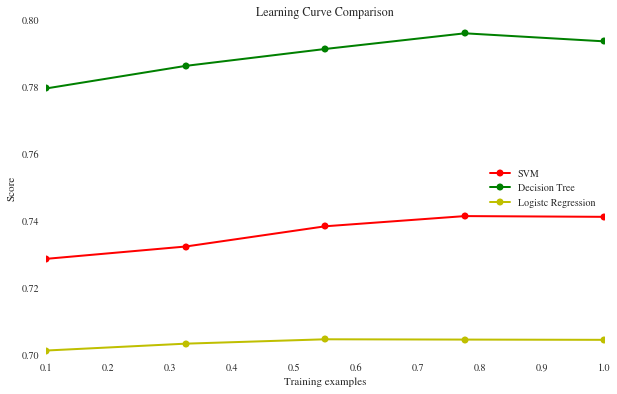

In [92]:
title = 'Learning Curve Comparison'
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10,
                                       test_size=0.2, random_state=0)
estimator1 = SVC(kernel='rbf', C=100, gamma=0.001, class_weight ='auto')
estimator2 = RandomForestClassifier(n_estimators=1, n_jobs=-1 ,class_weight='auto')
estimator3 = LogisticRegression(C=100, penalty='l2', class_weight = 'auto')
plot_learning_curve(estimator1,estimator2,estimator3, title, X, y, ylim=None, cv=cv, n_jobs=4)
plt.show()

# Ensemble votingclassifer 결과 분석

SVM과 randomforest, logistic regression 세가지 모델을 합쳐서 ensemble를 적용했습니다.

weight를 바꿔보면서 recall과 f1-score를 확인한 결과 다음과 같은 weight가 가장 좋은 결과를 얻는다고 결론내렸습니다.

In [37]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('rf', clf_rf),('lr', clf_logic)],
                        voting='soft',
                        weights=[2, 10])

In [38]:
eclf_pred = eclf.fit(X, y).predict(testX)
from sklearn import metrics
print(metrics.classification_report(testy, eclf_pred))

             precision    recall  f1-score   support

          0       0.92      0.79      0.85     12223
          1       0.35      0.63      0.45      2213

avg / total       0.83      0.77      0.79     14436



Confusion matrix
      0     1
0  9678  2545
1   829  1384

precision = 0.35, recall = 0.63, F1 = 0.45, accuracy = 0.77

          0         1
0  0.791786  1.150023
1  0.067823  0.625395


C:\Users\chibok\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


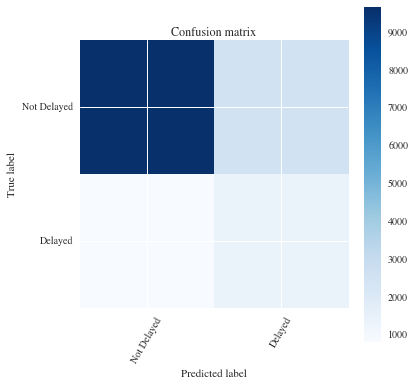

In [39]:
clf_ense = confusion_matrix(testy, eclf_pred)
print("Confusion matrix")
print(pd.DataFrame(clf_ense))
report_svc = precision_recall_fscore_support(list(testy), list(eclf_pred), average='micro')
print ("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % 
        (report_svc[0], report_svc[1], report_svc[2], accuracy_score(list(testy), list(eclf_pred))))
print(pd.DataFrame(clf_ense.astype(np.float64) / clf_ense.sum(axis=1)))
    
show_confusion_matrix(clf_ense)